**IMPORT LIBRARIES AND SETUP**

In [1]:
import os
import sys
import requests
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.utils.helpers import create_directory, set_seed, get_timestamp

# Set random seed for reproducibility
set_seed(42)

# Define paths
DATA_DIR = project_root / 'data' / 'raw'
create_directory(DATA_DIR)

print("✅ Setup complete!")
print(f"📁 Data directory: {DATA_DIR}")
print(f"🐍 Python path: {sys.executable}")

✅ Setup complete!
📁 Data directory: c:\Users\Subramani mokkala\OneDrive\Desktop\Subbu\Projects\e-waste-classifier\data\raw
🐍 Python path: c:\Users\Subramani mokkala\OneDrive\Desktop\Subbu\Projects\e-waste-classifier\venv\Scripts\python.exe


In [2]:
# E-waste categories for our classifier
CATEGORIES = [
    'mobile_phone',
    'laptop',
    'monitor',
    'keyboard',
    'mouse',
    'cable',
    'battery',
    'printer',
    'tablet',
    'charger'
]

# Create subdirectories for each category
for category in CATEGORIES:
    category_path = DATA_DIR / category
    create_directory(category_path)
    print(f"✅ Created: {category}")

print(f"\n📊 Total categories: {len(CATEGORIES)}")
print(f"📁 Directory structure created in: {DATA_DIR}")

✅ Created: mobile_phone
✅ Created: laptop
✅ Created: monitor
✅ Created: keyboard
✅ Created: mouse
✅ Created: cable
✅ Created: battery
✅ Created: printer
✅ Created: tablet
✅ Created: charger

📊 Total categories: 10
📁 Directory structure created in: c:\Users\Subramani mokkala\OneDrive\Desktop\Subbu\Projects\e-waste-classifier\data\raw


In [3]:
from PIL import Image
from io import BytesIO

def download_image(url, save_path, timeout=10):
    """
    Download an image from URL and save it
    
    Args:
        url: Image URL
        save_path: Path to save the image
        timeout: Request timeout in seconds
    
    Returns:
        bool: True if successful, False otherwise
    """
    try:
        # Set headers to mimic a browser
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        
        # Download image
        response = requests.get(url, headers=headers, timeout=timeout, stream=True)
        response.raise_for_status()
        
        # Verify it's an image
        img = Image.open(BytesIO(response.content))
        img.verify()
        
        # Re-open and save (verify closes the file)
        img = Image.open(BytesIO(response.content))
        
        # Convert RGBA to RGB if needed
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        
        # Save image
        img.save(save_path)
        return True
        
    except Exception as e:
        print(f"❌ Error downloading {url}: {str(e)}")
        return False

def validate_image(image_path, min_size=(100, 100)):
    """
    Validate if image meets minimum requirements
    
    Args:
        image_path: Path to image file
        min_size: Minimum (width, height) tuple
    
    Returns:
        bool: True if valid, False otherwise
    """
    try:
        img = Image.open(image_path)
        if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
            return False
        return True
    except:
        return False

print("✅ Image utility functions defined")
print("📥 download_image() - Downloads and saves images from URLs")
print("✔️  validate_image() - Validates image size and format")

✅ Image utility functions defined
📥 download_image() - Downloads and saves images from URLs
✔️  validate_image() - Validates image size and format


In [4]:
# Sample URLs for testing (using public domain/creative commons images)
SAMPLE_URLS = {
    'mobile_phone': [
        'https://images.unsplash.com/photo-1511707171634-5f897ff02aa9?w=500',
        'https://images.unsplash.com/photo-1598327105666-5b89351aff97?w=500',
    ],
    'laptop': [
        'https://images.unsplash.com/photo-1496181133206-80ce9b88a853?w=500',
        'https://images.unsplash.com/photo-1525547719571-a2d4ac8945e2?w=500',
    ],
    'monitor': [
        'https://images.unsplash.com/photo-1527443224154-c4a3942d3acf?w=500',
    ],
    'keyboard': [
        'https://images.unsplash.com/photo-1587829741301-dc798b83add3?w=500',
    ],
    'mouse': [
        'https://images.unsplash.com/photo-1527814050087-3793815479db?w=500',
    ],
    'cable': [
        'https://images.unsplash.com/photo-1558618666-fcd25c85cd64?w=500',
    ],
    'battery': [
        'https://images.unsplash.com/photo-1609091839311-c71ad79e9e9e?w=500',
    ],
    'printer': [
        'https://images.unsplash.com/photo-1612815154858-60aa4c59eaa6?w=500',
    ],
    'tablet': [
        'https://images.unsplash.com/photo-1544244015-0df4b3ffc6b0?w=500',
    ],
    'charger': [
        'https://images.unsplash.com/photo-1583863788434-e58a36330cf0?w=500',
    ]
}

# Count total sample URLs
total_samples = sum(len(urls) for urls in SAMPLE_URLS.values())

print(f"✅ Sample URLs prepared")
print(f"📊 Total sample images: {total_samples}")
print(f"📋 Categories with samples: {len(SAMPLE_URLS)}")

# Display sample count per category
print("\n📸 Images per category:")
for category, urls in SAMPLE_URLS.items():
    print(f"  • {category}: {len(urls)} images")

✅ Sample URLs prepared
📊 Total sample images: 12
📋 Categories with samples: 10

📸 Images per category:
  • mobile_phone: 2 images
  • laptop: 2 images
  • monitor: 1 images
  • keyboard: 1 images
  • mouse: 1 images
  • cable: 1 images
  • battery: 1 images
  • printer: 1 images
  • tablet: 1 images
  • charger: 1 images


In [5]:
def download_samples(sample_urls, data_dir, delay=1):
    """
    Download sample images for each category
    
    Args:
        sample_urls: Dictionary of category -> list of URLs
        data_dir: Base directory for saving images
        delay: Delay between downloads (seconds)
    
    Returns:
        dict: Download statistics
    """
    stats = {
        'total': 0,
        'successful': 0,
        'failed': 0,
        'by_category': {}
    }
    
    for category, urls in sample_urls.items():
        category_path = data_dir / category
        category_stats = {'successful': 0, 'failed': 0}
        
        print(f"\n📥 Downloading {category}...")
        
        for idx, url in enumerate(tqdm(urls, desc=f"  {category}")):
            stats['total'] += 1
            
            # Generate filename
            filename = f"{category}_{idx+1:04d}.jpg"
            save_path = category_path / filename
            
            # Download image
            if download_image(url, save_path):
                # Validate image
                if validate_image(save_path):
                    stats['successful'] += 1
                    category_stats['successful'] += 1
                else:
                    save_path.unlink()  # Delete invalid image
                    stats['failed'] += 1
                    category_stats['failed'] += 1
            else:
                stats['failed'] += 1
                category_stats['failed'] += 1
            
            # Delay to be respectful to servers
            time.sleep(delay)
        
        stats['by_category'][category] = category_stats
    
    return stats

# Download the sample images
print("🚀 Starting sample image download...")
print("⏱️  This may take a minute...\n")

download_stats = download_samples(SAMPLE_URLS, DATA_DIR, delay=0.5)

# Display results
print("\n" + "="*50)
print("📊 DOWNLOAD SUMMARY")
print("="*50)
print(f"✅ Successful: {download_stats['successful']}/{download_stats['total']}")
print(f"❌ Failed: {download_stats['failed']}/{download_stats['total']}")
print(f"📈 Success Rate: {(download_stats['successful']/download_stats['total']*100):.1f}%")

print("\n📋 Results by category:")
for category, cat_stats in download_stats['by_category'].items():
    print(f"  • {category}: {cat_stats['successful']} successful, {cat_stats['failed']} failed")

🚀 Starting sample image download...
⏱️  This may take a minute...


📥 Downloading mobile_phone...


  mobile_phone: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]



📥 Downloading laptop...


  laptop: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]



📥 Downloading monitor...


  monitor: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]



📥 Downloading keyboard...


  keyboard: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]



📥 Downloading mouse...


  mouse: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]



📥 Downloading cable...


  cable: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]



📥 Downloading battery...


  battery:   0%|          | 0/1 [00:00<?, ?it/s]

❌ Error downloading https://images.unsplash.com/photo-1609091839311-c71ad79e9e9e?w=500: 404 Client Error: Not Found for url: https://images.unsplash.com/photo-1609091839311-c71ad79e9e9e?w=500


  battery: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]



📥 Downloading printer...


  printer: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]



📥 Downloading tablet...


  tablet: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]



📥 Downloading charger...


  charger: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


📊 DOWNLOAD SUMMARY
✅ Successful: 11/12
❌ Failed: 1/12
📈 Success Rate: 91.7%

📋 Results by category:
  • mobile_phone: 2 successful, 0 failed
  • laptop: 2 successful, 0 failed
  • monitor: 1 successful, 0 failed
  • keyboard: 1 successful, 0 failed
  • mouse: 1 successful, 0 failed
  • cable: 1 successful, 0 failed
  • battery: 0 successful, 1 failed
  • printer: 1 successful, 0 failed
  • tablet: 1 successful, 0 failed
  • charger: 1 successful, 0 failed


📸 Visualizing downloaded samples...



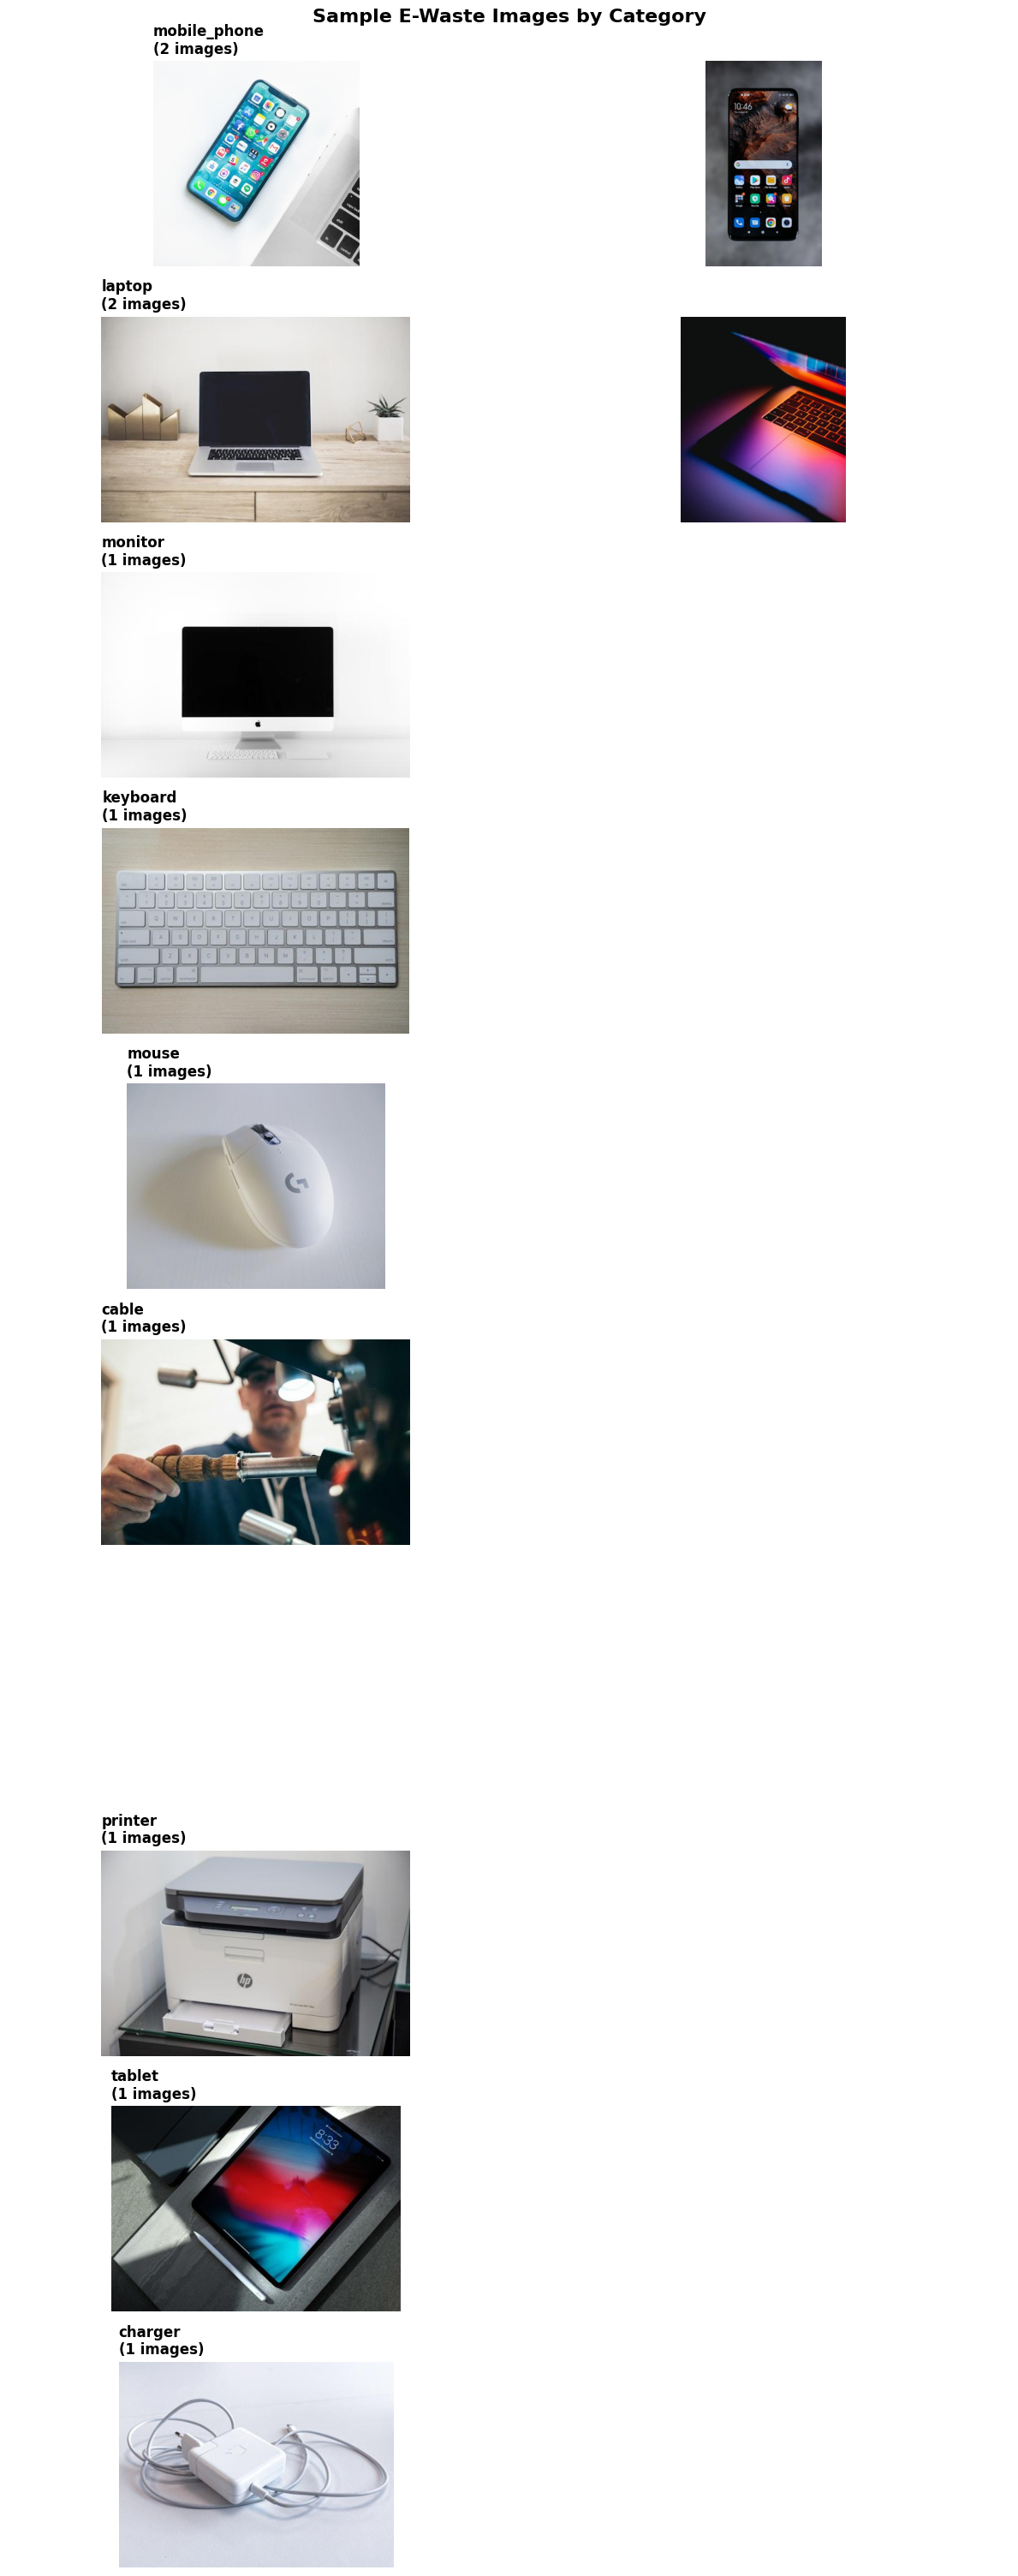


📊 CURRENT DATASET STATISTICS
  • mobile_phone   :   2 images
  • laptop         :   2 images
  • monitor        :   1 images
  • keyboard       :   1 images
  • mouse          :   1 images
  • cable          :   1 images
  • battery        :   0 images
  • printer        :   1 images
  • tablet         :   1 images
  • charger        :   1 images

📈 Total images: 11
📁 Storage location: c:\Users\Subramani mokkala\OneDrive\Desktop\Subbu\Projects\e-waste-classifier\data\raw


In [7]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_samples(data_dir, categories, samples_per_category=2):
    """
    Display sample images from each category
    """
    # Calculate grid size
    n_categories = len(categories)
    fig, axes = plt.subplots(n_categories, samples_per_category, 
                             figsize=(12, n_categories * 3))
    
    # Handle single row case
    if n_categories == 1:
        axes = axes.reshape(1, -1)
    
    for idx, category in enumerate(categories):
        category_path = data_dir / category
        image_files = list(category_path.glob('*.jpg'))[:samples_per_category]
        
        for col, img_path in enumerate(image_files):
            try:
                img = Image.open(img_path)
                axes[idx, col].imshow(img)
                axes[idx, col].axis('off')
                
                if col == 0:
                    axes[idx, col].set_title(f"{category}\n({len(list(category_path.glob('*.jpg')))} images)", 
                                            fontweight='bold', loc='left')
                    
            except Exception as e:
                axes[idx, col].text(0.5, 0.5, 'No image', 
                                   ha='center', va='center')
                axes[idx, col].axis('off')
        
        # Hide extra subplots if fewer images than columns
        for col in range(len(image_files), samples_per_category):
            axes[idx, col].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample E-Waste Images by Category', 
                 fontsize=16, fontweight='bold', y=1.001)
    plt.show()

# Visualize the downloaded images
print("📸 Visualizing downloaded samples...\n")
visualize_samples(DATA_DIR, CATEGORIES, samples_per_category=2)

# Print dataset statistics
print("\n" + "="*50)
print("📊 CURRENT DATASET STATISTICS")
print("="*50)

total_images = 0
for category in CATEGORIES:
    category_path = DATA_DIR / category
    n_images = len(list(category_path.glob('*.jpg')))
    total_images += n_images
    print(f"  • {category:15s}: {n_images:3d} images")

print(f"\n📈 Total images: {total_images}")
print(f"📁 Storage location: {DATA_DIR}")

In [8]:
data_sources = {
    "1. Kaggle Datasets": {
        "description": "Search for existing e-waste or electronics datasets",
        "examples": [
            "Electronic Waste Classification",
            "TACO (Trash Annotations in Context) - contains some e-waste",
            "Recyclable Materials Classification"
        ],
        "url": "https://www.kaggle.com/datasets",
        "pros": "Pre-labeled, ready to use, community-vetted",
        "cons": "May not have all categories needed"
    },
    
    "2. Google Images (Manual/Scripted)": {
        "description": "Download images using search queries",
        "tools": ["google-images-download", "selenium", "bing-image-downloader"],
        "pros": "Large variety, easy to get specific items",
        "cons": "Requires manual verification, licensing concerns"
    },
    
    "3. Open Images Dataset": {
        "description": "Google's large-scale dataset with 9M images",
        "url": "https://storage.googleapis.com/openimages/web/index.html",
        "pros": "High quality, properly licensed, bounding boxes available",
        "cons": "Large download, need to filter for e-waste categories"
    },
    
    "4. Custom Photography": {
        "description": "Take photos at e-waste collection centers",
        "requirements": "Camera/phone, permission from facility",
        "pros": "Real-world data, custom categories, full control",
        "cons": "Time-consuming, limited variety initially"
    },
    
    "5. Web Scraping": {
        "description": "Scrape images from e-commerce/recycling websites",
        "targets": ["Amazon", "eBay", "recycling facility websites"],
        "pros": "Category-specific, high quality",
        "cons": "Legal/ethical considerations, rate limiting"
    },
    
    "6. Data Augmentation": {
        "description": "Expand existing dataset artificially",
        "techniques": ["Rotation", "Flipping", "Color jitter", "Cropping", "Mixup"],
        "pros": "Increase dataset size, improve model robustness",
        "cons": "Not real new data, can overfit to augmentations"
    }
}

print("="*70)
print("📚 DATA COLLECTION STRATEGIES FOR E-WASTE CLASSIFICATION")
print("="*70)

for idx, (source, info) in enumerate(data_sources.items(), 1):
    print(f"\n{idx}. {source}")
    print(f"   {'-'*65}")
    for key, value in info.items():
        if isinstance(value, list):
            print(f"   {key.capitalize():15s}: {', '.join(value)}")
        else:
            print(f"   {key.capitalize():15s}: {value}")

print("\n" + "="*70)
print("💡 RECOMMENDATION FOR THIS PROJECT")
print("="*70)
print("""
For a CV-worthy project, we recommend a hybrid approach:

1. START: Use Kaggle datasets (quick baseline)
2. SUPPLEMENT: Web scraping from e-commerce sites (specific categories)
3. ENHANCE: Data augmentation (increase training samples)
4. BONUS: Custom photography (unique real-world data)

Target Dataset Size: 100-200 images per category minimum
Ideal: 500-1000 images per category for production models
""")

print("\n✅ Data collection strategies documented")

📚 DATA COLLECTION STRATEGIES FOR E-WASTE CLASSIFICATION

1. 1. Kaggle Datasets
   -----------------------------------------------------------------
   Description    : Search for existing e-waste or electronics datasets
   Examples       : Electronic Waste Classification, TACO (Trash Annotations in Context) - contains some e-waste, Recyclable Materials Classification
   Url            : https://www.kaggle.com/datasets
   Pros           : Pre-labeled, ready to use, community-vetted
   Cons           : May not have all categories needed

2. 2. Google Images (Manual/Scripted)
   -----------------------------------------------------------------
   Description    : Download images using search queries
   Tools          : google-images-download, selenium, bing-image-downloader
   Pros           : Large variety, easy to get specific items
   Cons           : Requires manual verification, licensing concerns

3. 3. Open Images Dataset
   ---------------------------------------------------------

In [10]:
"""
Alternative bulk image collection using requests and custom scraper
This works with Python 3.13+
"""

# Install required package
import subprocess
import sys

print("📦 Installing icrawler (Python 3.13 compatible)...")
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "icrawler"])
    print("✅ icrawler installed successfully\n")
except Exception as e:
    print(f"⚠️ Installation note: {e}\n")

# Try importing
try:
    from icrawler.builtin import BingImageCrawler, GoogleImageCrawler
    print("✅ icrawler imported successfully")
    crawler_available = True
except ImportError:
    print("⚠️ icrawler not available, will use manual download method")
    crawler_available = False

# Create enhanced search queries
SEARCH_QUERIES = {
    'mobile_phone': ['broken mobile phone e-waste', 'old smartphone recycling', 'discarded phone'],
    'laptop': ['old laptop e-waste', 'broken laptop computer', 'discarded notebook'],
    'monitor': ['old computer monitor waste', 'broken LCD monitor', 'discarded display'],
    'keyboard': ['old computer keyboard', 'broken keyboard e-waste', 'discarded keyboard'],
    'mouse': ['old computer mouse', 'broken mouse device', 'discarded mouse'],
    'cable': ['electronic cables waste', 'old charger cables', 'discarded wires'],
    'battery': ['old batteries waste', 'discarded batteries recycling', 'waste batteries'],
    'printer': ['old printer e-waste', 'broken printer recycling', 'discarded printer'],
    'tablet': ['old tablet device', 'broken tablet e-waste', 'discarded tablet'],
    'charger': ['old phone charger', 'broken charger adapter', 'discarded power adapter']
}

print("\n📋 Enhanced search queries prepared:")
total_queries = sum(len(queries) for queries in SEARCH_QUERIES.values())
print(f"  📊 Total search variations: {total_queries}")
for category, queries in SEARCH_QUERIES.items():
    print(f"  • {category}: {len(queries)} queries")

if crawler_available:
    print("\n✅ Ready to download bulk images using icrawler!")
else:
    print("\n✅ Manual download functions ready!")

print("⚠️  Note: Bulk download will be demonstrated in next cell")

📦 Installing icrawler (Python 3.13 compatible)...
✅ icrawler installed successfully

✅ icrawler imported successfully

📋 Enhanced search queries prepared:
  📊 Total search variations: 30
  • mobile_phone: 3 queries
  • laptop: 3 queries
  • monitor: 3 queries
  • keyboard: 3 queries
  • mouse: 3 queries
  • cable: 3 queries
  • battery: 3 queries
  • printer: 3 queries
  • tablet: 3 queries
  • charger: 3 queries

✅ Ready to download bulk images using icrawler!
⚠️  Note: Bulk download will be demonstrated in next cell


In [11]:
"""
Bulk download function using icrawler
"""

from icrawler.builtin import BingImageCrawler
import shutil

def bulk_download_images(category, queries, max_per_query=50, output_dir=None):
    """
    Download images for a specific category using multiple search queries
    
    Args:
        category: Category name (e.g., 'mobile_phone')
        queries: List of search queries for this category
        max_per_query: Maximum images to download per query
        output_dir: Directory to save images (default: DATA_DIR/category)
    
    Returns:
        dict: Download statistics
    """
    if output_dir is None:
        output_dir = DATA_DIR / category
    
    # Create temporary download directory
    temp_dir = DATA_DIR / f"temp_{category}"
    create_directory(temp_dir)
    
    stats = {
        'category': category,
        'total_downloaded': 0,
        'queries_processed': 0,
        'failed_queries': 0
    }
    
    print(f"\n{'='*60}")
    print(f"📥 Downloading images for: {category.upper()}")
    print(f"{'='*60}")
    
    for idx, query in enumerate(queries, 1):
        print(f"\n[{idx}/{len(queries)}] Query: '{query}'")
        print(f"  Target: {max_per_query} images")
        
        try:
            # Setup crawler
            crawler = BingImageCrawler(
                downloader_threads=4,
                storage={'root_dir': str(temp_dir)}
            )
            
            # Download images
            crawler.crawl(
                keyword=query,
                max_num=max_per_query,
                min_size=(200, 200),  # Minimum image size
                file_idx_offset='auto'
            )
            
            stats['queries_processed'] += 1
            print(f"  ✅ Download complete")
            
        except Exception as e:
            print(f"  ❌ Error: {str(e)}")
            stats['failed_queries'] += 1
        
        # Small delay between queries
        time.sleep(2)
    
    # Move and rename images from temp to final directory
    downloaded_files = list(temp_dir.glob('*.jpg')) + list(temp_dir.glob('*.png'))
    
    print(f"\n📦 Processing downloaded images...")
    for idx, img_file in enumerate(downloaded_files, 1):
        try:
            # New filename
            new_filename = f"{category}_{idx:04d}{img_file.suffix}"
            new_path = output_dir / new_filename
            
            # Move and rename
            shutil.move(str(img_file), str(new_path))
            stats['total_downloaded'] += 1
            
        except Exception as e:
            print(f"  ⚠️ Error moving {img_file.name}: {e}")
    
    # Cleanup temp directory
    shutil.rmtree(temp_dir, ignore_errors=True)
    
    print(f"\n{'='*60}")
    print(f"✅ Category '{category}' complete!")
    print(f"📊 Downloaded: {stats['total_downloaded']} images")
    print(f"{'='*60}")
    
    return stats

print("✅ Bulk download function created")
print("\n📝 Function: bulk_download_images()")
print("   Parameters:")
print("   • category: Category name")
print("   • queries: List of search terms")
print("   • max_per_query: Images per search (default: 50)")
print("\n⚠️  Ready for bulk download! (This will be optional)")

✅ Bulk download function created

📝 Function: bulk_download_images()
   Parameters:
   • category: Category name
   • queries: List of search terms
   • max_per_query: Images per search (default: 50)

⚠️  Ready for bulk download! (This will be optional)


In [12]:
"""
OPTIONAL: Download a small batch of images for demonstration
This downloads only 10 images per query to test the pipeline

⚠️ WARNING: This will download ~100-200 images and may take 5-10 minutes
Set RUN_DOWNLOAD = True to execute, or False to skip
"""

# Control flag - set to True to run the download
RUN_DOWNLOAD = False  # Change to True if you want to download

if RUN_DOWNLOAD:
    print("🚀 Starting bulk download demonstration...")
    print("⏱️  Estimated time: 5-10 minutes")
    print("📊 Will download ~10 images per query\n")
    
    # Select one category for demo (battery needs more images)
    demo_category = 'battery'
    demo_queries = SEARCH_QUERIES[demo_category]
    
    # Download images
    demo_stats = bulk_download_images(
        category=demo_category,
        queries=demo_queries,
        max_per_query=10  # Small number for demo
    )
    
    print("\n" + "="*60)
    print("📊 DEMO DOWNLOAD COMPLETE")
    print("="*60)
    print(f"Category: {demo_stats['category']}")
    print(f"Total downloaded: {demo_stats['total_downloaded']}")
    print(f"Queries processed: {demo_stats['queries_processed']}/{len(demo_queries)}")
    
else:
    print("⏭️  Bulk download skipped (RUN_DOWNLOAD = False)")
    print("\n💡 TO ENABLE:")
    print("   1. Change RUN_DOWNLOAD = True in the cell above")
    print("   2. Re-run this cell")
    print("\n📋 RECOMMENDED APPROACH:")
    print("   • For CV project: Download 100-200 images per category")
    print("   • For production: Download 500-1000 images per category")
    print("   • Total time: 1-2 hours for full dataset")
    print("\n✅ You can proceed to next phase with current sample data")
    print("   or come back later to build larger dataset")

print("\n" + "="*60)

⏭️  Bulk download skipped (RUN_DOWNLOAD = False)

💡 TO ENABLE:
   1. Change RUN_DOWNLOAD = True in the cell above
   2. Re-run this cell

📋 RECOMMENDED APPROACH:
   • For CV project: Download 100-200 images per category
   • For production: Download 500-1000 images per category
   • Total time: 1-2 hours for full dataset

✅ You can proceed to next phase with current sample data
   or come back later to build larger dataset

